In [ ]:
# SARS-CoV-2 infection dynamics: clustering + cell-type identification + pseudotime
# Reproduce neighbourhood clustering and cell type ID for GSE166766
# Reference: Ravindra et al., PLOS Biology (GSE166766). See links/DOI in the notebook header.


In [1]:
pip install --upgrade scanpy anndata scvelo leidenalg matplotlib seaborn umap-learn scikit-misc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.8/196.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.0 MB/s eta 0:00:00
  Created whe

In [6]:
# Imports
import os
import scanpy as sc
import scvelo as scv
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, figsize=(6,6))

In [3]:
def load_dataset(path, condition):
    adata = sc.read_10x_mtx(path, var_names='gene_symbols')
    adata.obs['condition'] = condition

    # QC gene flags
    adata.var['MT']   = adata.var_names.str.startswith("MT-")
    adata.var['RIBO'] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var['HB']   = adata.var_names.str.match(r"^HB[^P]")

    return adata

In [5]:
import scanpy as sc

# Download and extract the GSE166766 raw data
# Remove existing corrupted tar files if they exist
!rm -f GSE166766_RAW.tar GSE166766_RAW.tar.1
# Force re-download
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar
!tar -xvf GSE166766_RAW.tar

# Create directories and move/rename files
!mkdir -p mock 1dpi 2dpi 3dpi
!mv GSM5082289_mock_barcodes.tsv.gz mock/barcodes.tsv.gz
!mv GSM5082289_mock_features.tsv.gz mock/features.tsv.gz
!mv GSM5082289_mock_matrix.mtx.gz mock/matrix.mtx.gz

!mv GSM5082290_1dpi_barcodes.tsv.gz 1dpi/barcodes.tsv.gz
!mv GSM5082290_1dpi_features.tsv.gz 1dpi/features.tsv.gz
!mv GSM5082290_1dpi_matrix.mtx.gz 1dpi/matrix.mtx.gz

!mv GSM5082291_2dpi_barcodes.tsv.gz 2dpi/barcodes.tsv.gz
!mv GSM5082291_2dpi_features.tsv.gz 2dpi/features.tsv.gz
!mv GSM5082291_2dpi_matrix.mtx.gz 2dpi/matrix.mtx.gz

!mv GSM5082292_3dpi_barcodes.tsv.gz 3dpi/barcodes.tsv.gz
!mv GSM5082292_3dpi_features.tsv.gz 3dpi/features.tsv.gz
!mv GSM5082292_3dpi_matrix.mtx.gz 3dpi/matrix.mtx.gz

mock      = load_dataset("mock/",  "mock")
dpi1      = load_dataset("1dpi/",  "1dpi")
dpi2      = load_dataset("2dpi/",  "2dpi")
dpi3      = load_dataset("3dpi/",  "3dpi")

mock, dpi1, dpi2, dpi3

--2025-12-03 17:15:15--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar
           => ‘GSE166766_RAW.tar’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.11, 130.14.250.12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE166nnn/GSE166766/suppl ... done.
==> SIZE GSE166766_RAW.tar ... 838123520
==> PASV ... done.    ==> RETR GSE166766_RAW.tar ... done.
Length: 838123520 (799M) (unauthoritative)

GSE166766_RAW.tar   100%[===================>] 799.30M  89.7MB/s    in 11s     

2025-12-03 17:15:26 (74.8 MB/s) - ‘GSE166766_RAW.tar’ saved [838123520]

GSM5082289_mock_barcodes.tsv.gz
GSM5082289_mock_features.tsv.gz
GSM5082289_mock_matrix.mtx.gz
GSM5082290_1dpi_barcodes.tsv.gz
GSM5082290_1dpi_features.tsv.gz
GSM5082290_1dpi_matrix.mtx.gz
GSM5082291_2dpi_ba

(AnnData object with n_obs × n_vars = 22609 × 33539
     obs: 'condition'
     var: 'gene_ids', 'feature_types', 'MT', 'RIBO', 'HB',
 AnnData object with n_obs × n_vars = 11834 × 33539
     obs: 'condition'
     var: 'gene_ids', 'feature_types', 'MT', 'RIBO', 'HB',
 AnnData object with n_obs × n_vars = 14695 × 33539
     obs: 'condition'
     var: 'gene_ids', 'feature_types', 'MT', 'RIBO', 'HB',
 AnnData object with n_obs × n_vars = 28530 × 33539
     obs: 'condition'
     var: 'gene_ids', 'feature_types', 'MT', 'RIBO', 'HB')

In [7]:
# 3) QC metrics — compute stats used to filter low-quality cells

for ds in [mock, dpi1, dpi2, dpi3]:
    sc.pp.calculate_qc_metrics(
        ds,
        qc_vars=["MT", "RIBO", "HB"],  # columns defined earlier
        inplace=True,
        log1p=True
    )


QC violin plots for: mock


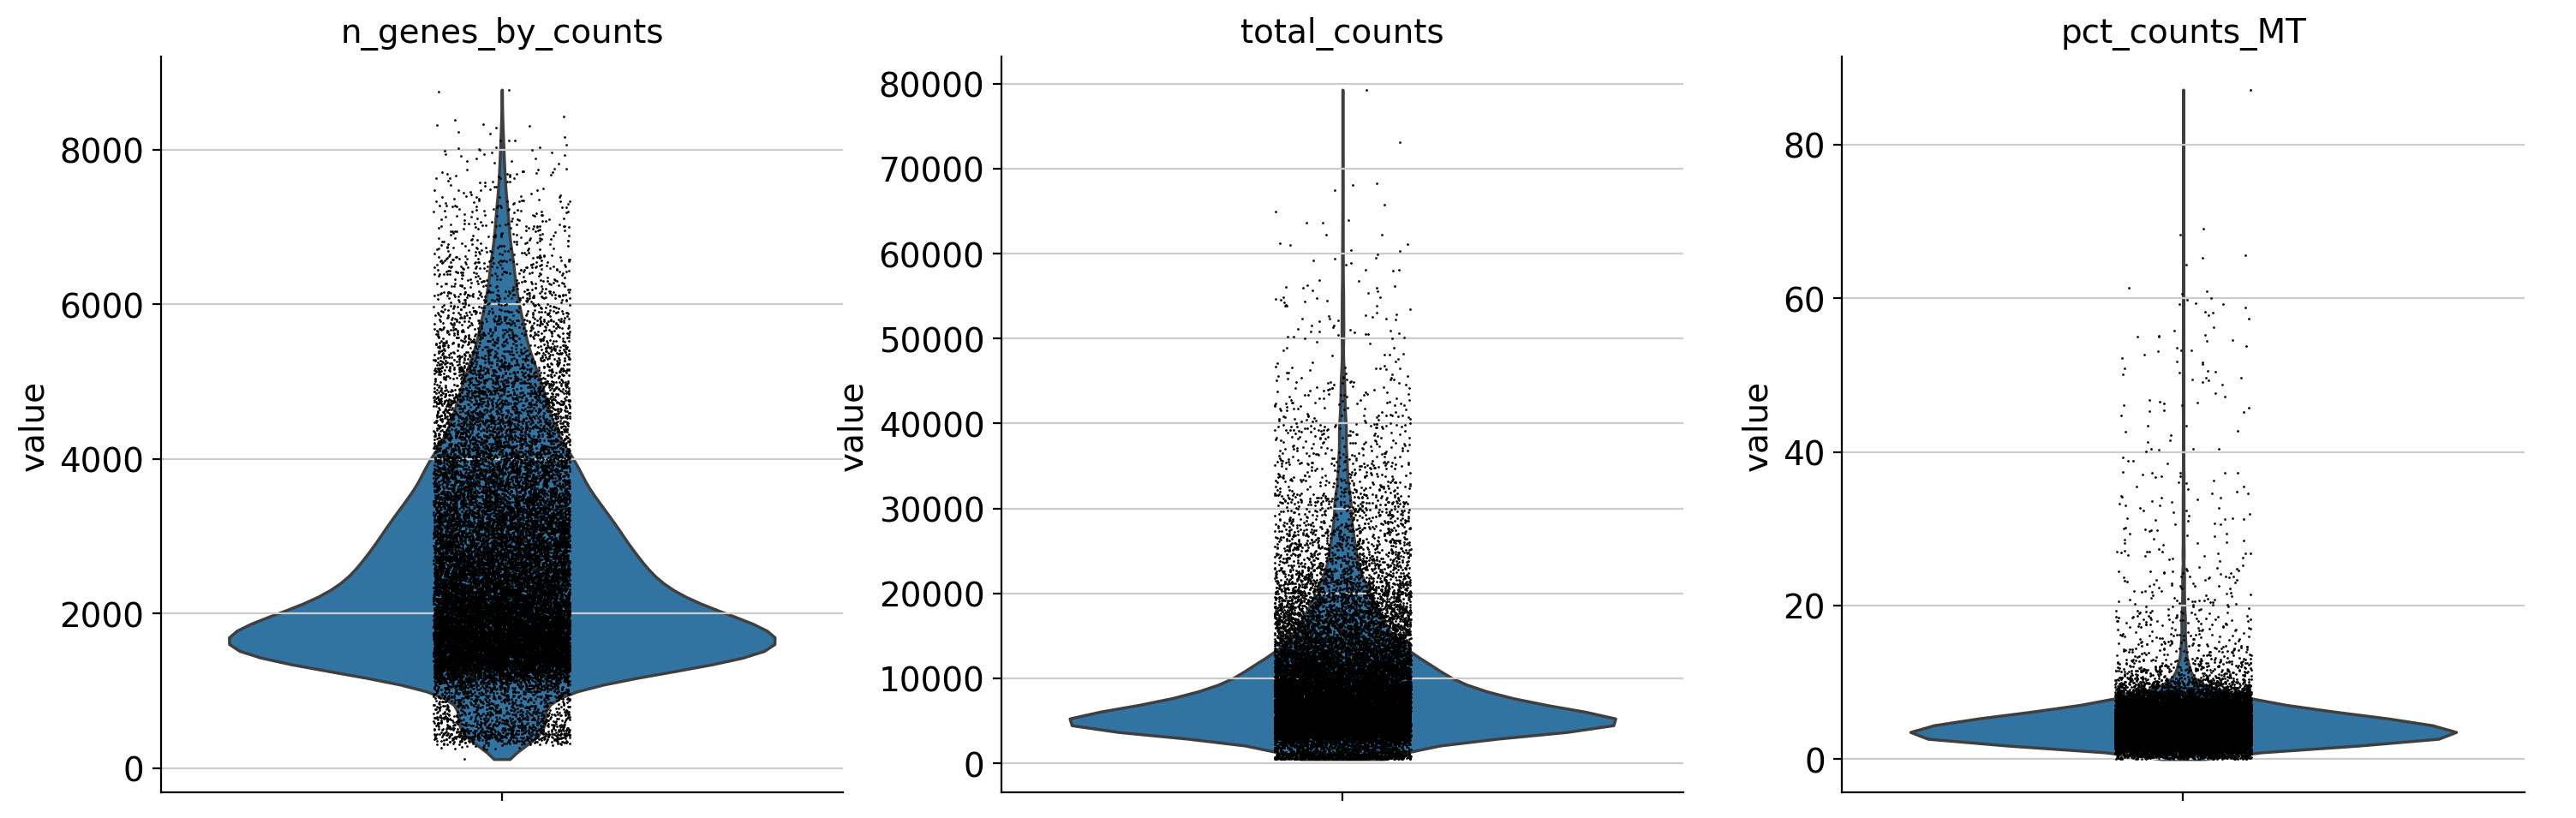


QC violin plots for: 1dpi


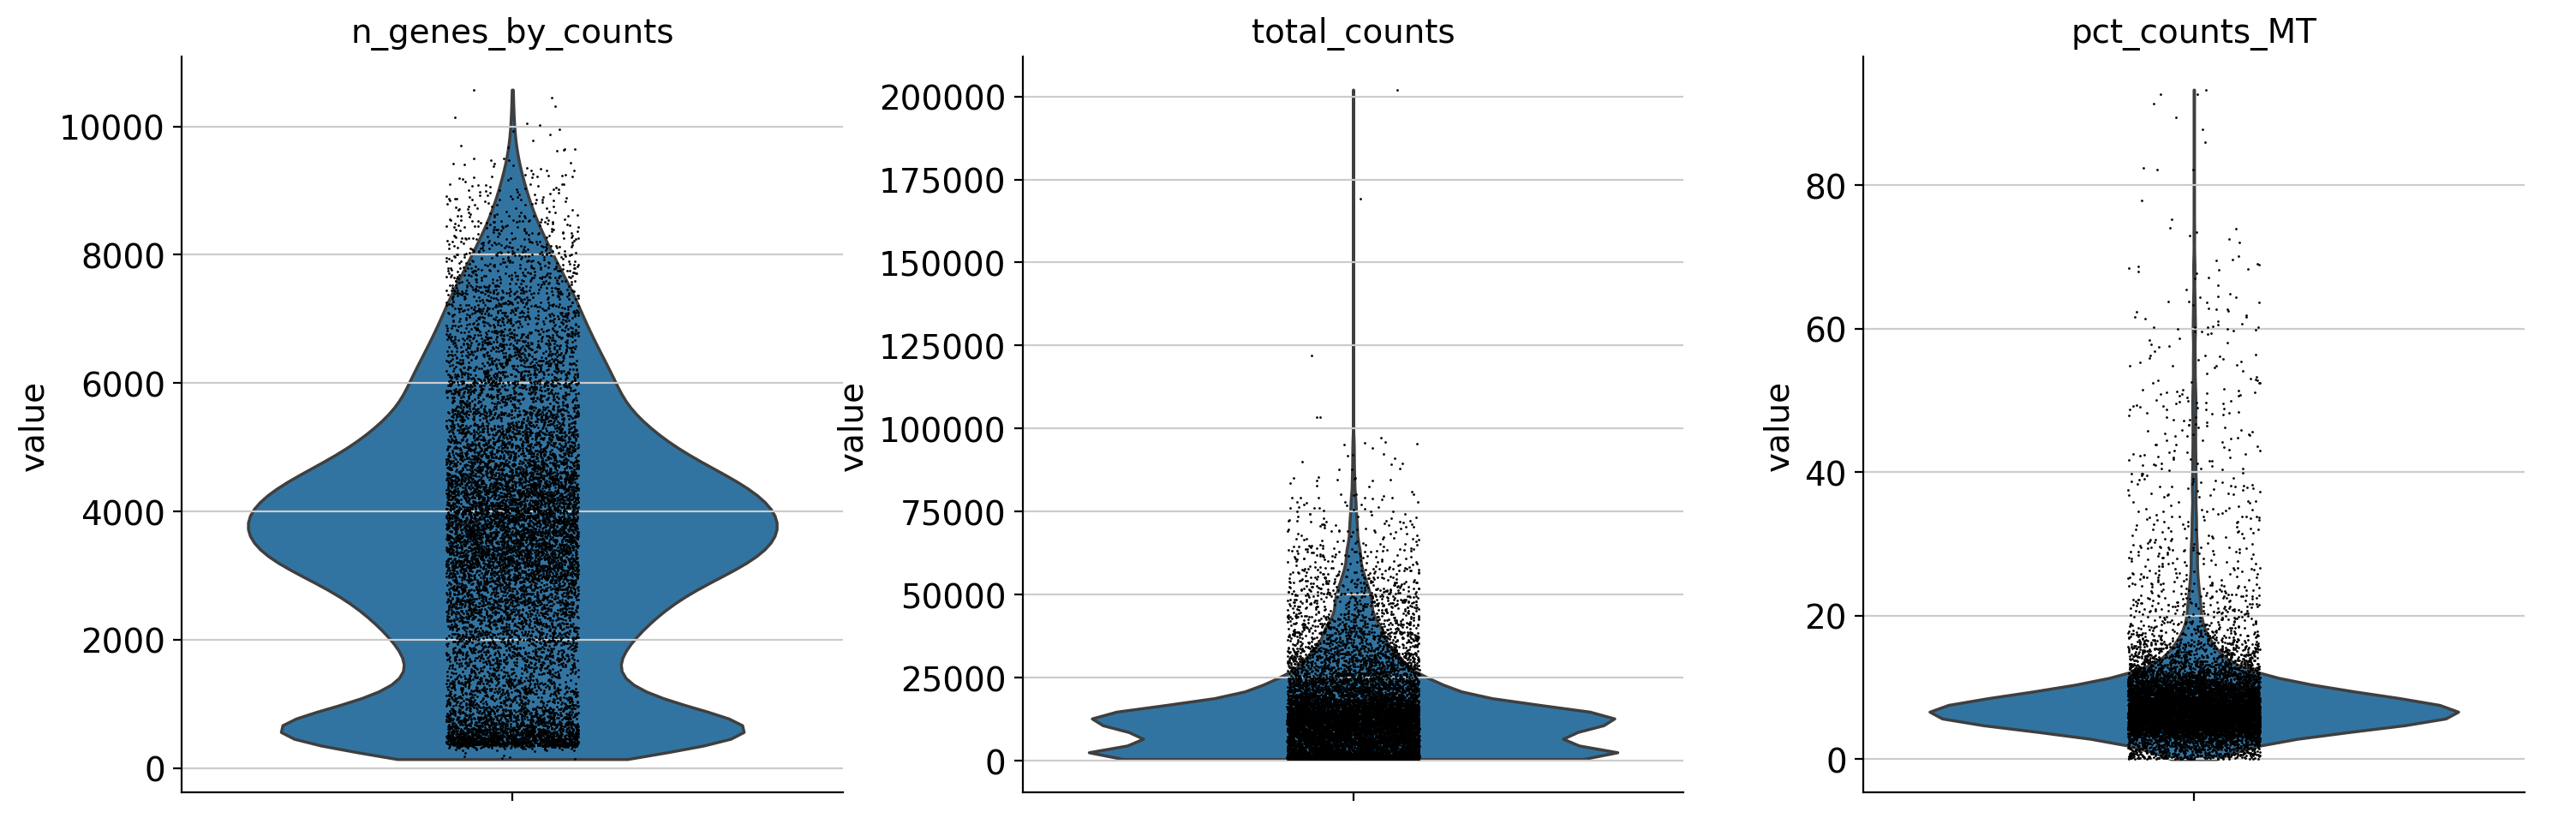


QC violin plots for: 2dpi


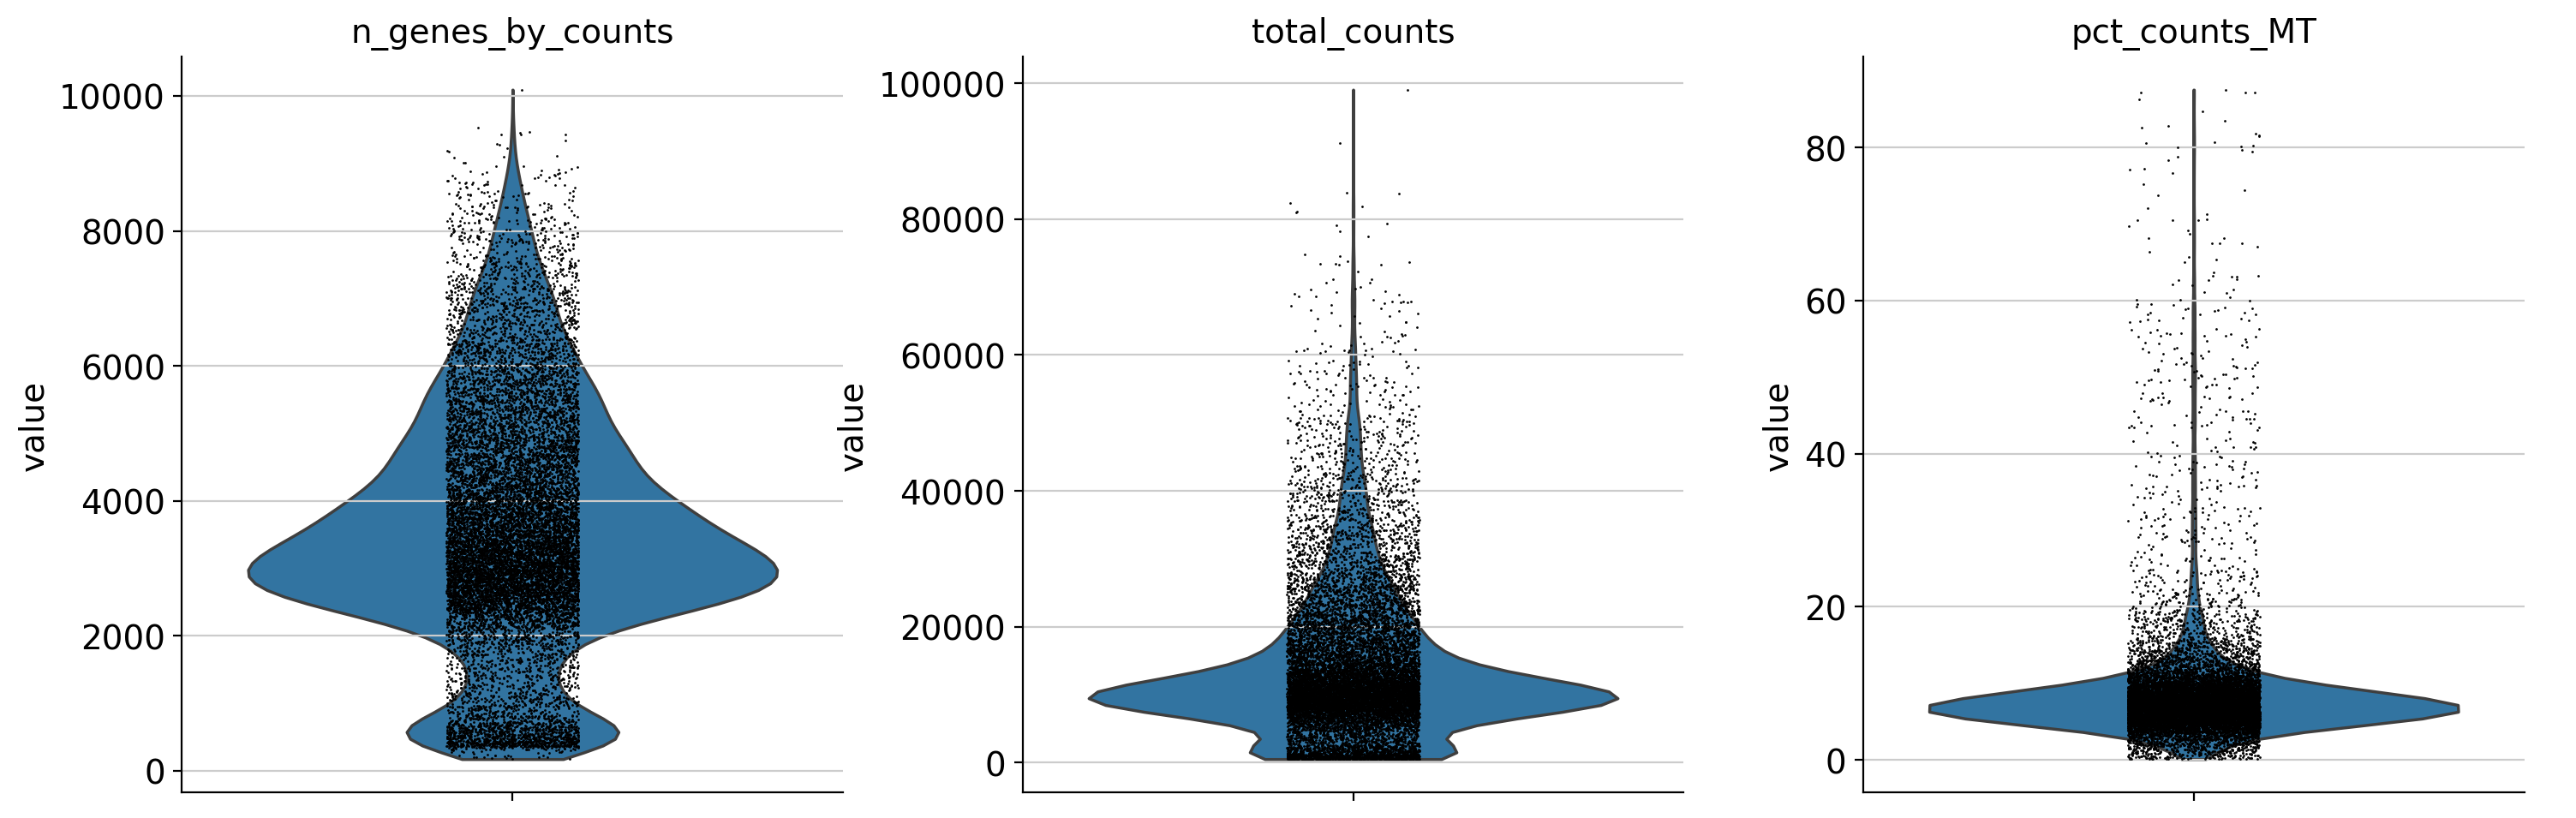


QC violin plots for: 3dpi


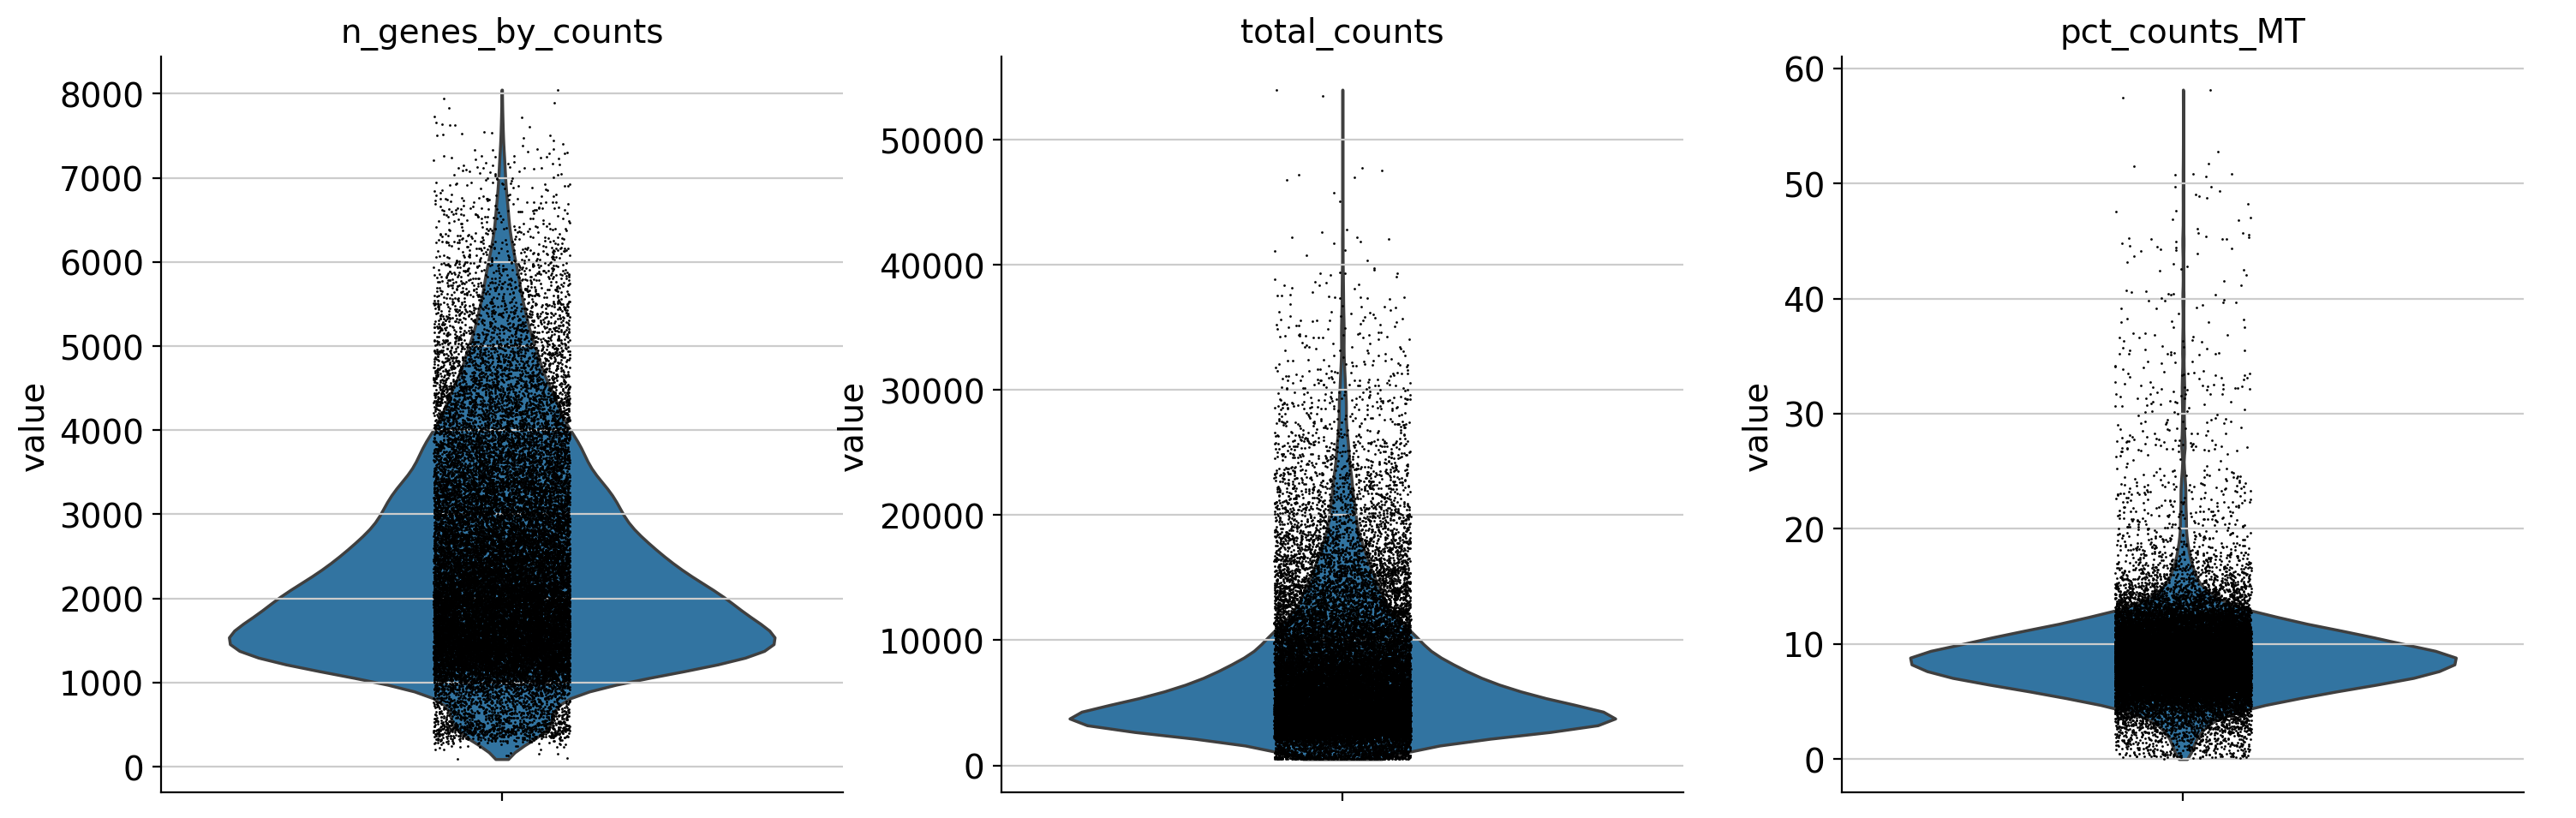

In [8]:
# Visualize QC distributions
for name, ds in zip(["mock","1dpi","2dpi","3dpi"], [mock, dpi1, dpi2, dpi3]):
    print(f"\nQC violin plots for: {name}")
    sc.pl.violin(
        ds,
        ["n_genes_by_counts", "total_counts", "pct_counts_MT"],
        multi_panel=True
    )

In [9]:
# 4) Filter out damaged / low-quality cells

def filter_cells(adata):
    """
    Applies standard scRNA-seq cell filtering:
    - remove cells with too few genes
    - remove cells with high mitochondrial percentage (dying cells)
    """
    adata = adata[adata.obs['n_genes_by_counts'] > 200, :]     # keep sufficiently complex cells
    adata = adata[adata.obs['pct_counts_MT'] < 20, :]          # drop cells with high MT stress
    return adata

mock_f = filter_cells(mock)
dpi1_f = filter_cells(dpi1)
dpi2_f = filter_cells(dpi2)
dpi3_f = filter_cells(dpi3)

In [10]:
import anndata as ad

# 5) Concatenate (merge into one single AnnData object)

# This keeps track of batch/sample origin inside adata.obs['batch']
adata = ad.concat([mock_f, dpi1_f, dpi2_f, dpi3_f],
                  label="batch",
                  merge="same")

print("\nCombined dataset:")
print(adata)


Combined dataset:
AnnData object with n_obs × n_vars = 75871 × 33539
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_HB', 'log1p_total_counts_HB', 'pct_counts_HB', 'batch'
    var: 'gene_ids', 'feature_types', 'MT', 'RIBO', 'HB'


In [11]:
# 6) Normalization + log transform + HVG selection

# Normalize counts per cell (CPM-like)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform for stabilizing variance
# Re-adding this as it's recommended for 'seurat' flavor HVG selection
sc.pp.log1p(adata)

# Identify top highly-variable genes
# Changed flavor to 'seurat' as it is more appropriate for pre-normalized and log-transformed data
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat',
    n_top_genes=3000
)

normalizing counts per cell
    finished (0:00:05)
extracting highly variable genes
    finished (0:00:10)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [12]:
# Use only HVGs for downstream steps
adata = adata[:, adata.var['highly_variable']]

# Regress out technical effects, then scale each gene to unit variance
sc.pp.scale(adata, max_value=10)

In [14]:
# 7) Dimensionality reduction (PCA) + neighborhood graph

sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

computing PCA
    with n_comps=50
    finished (0:01:13)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:46)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:31)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:05)


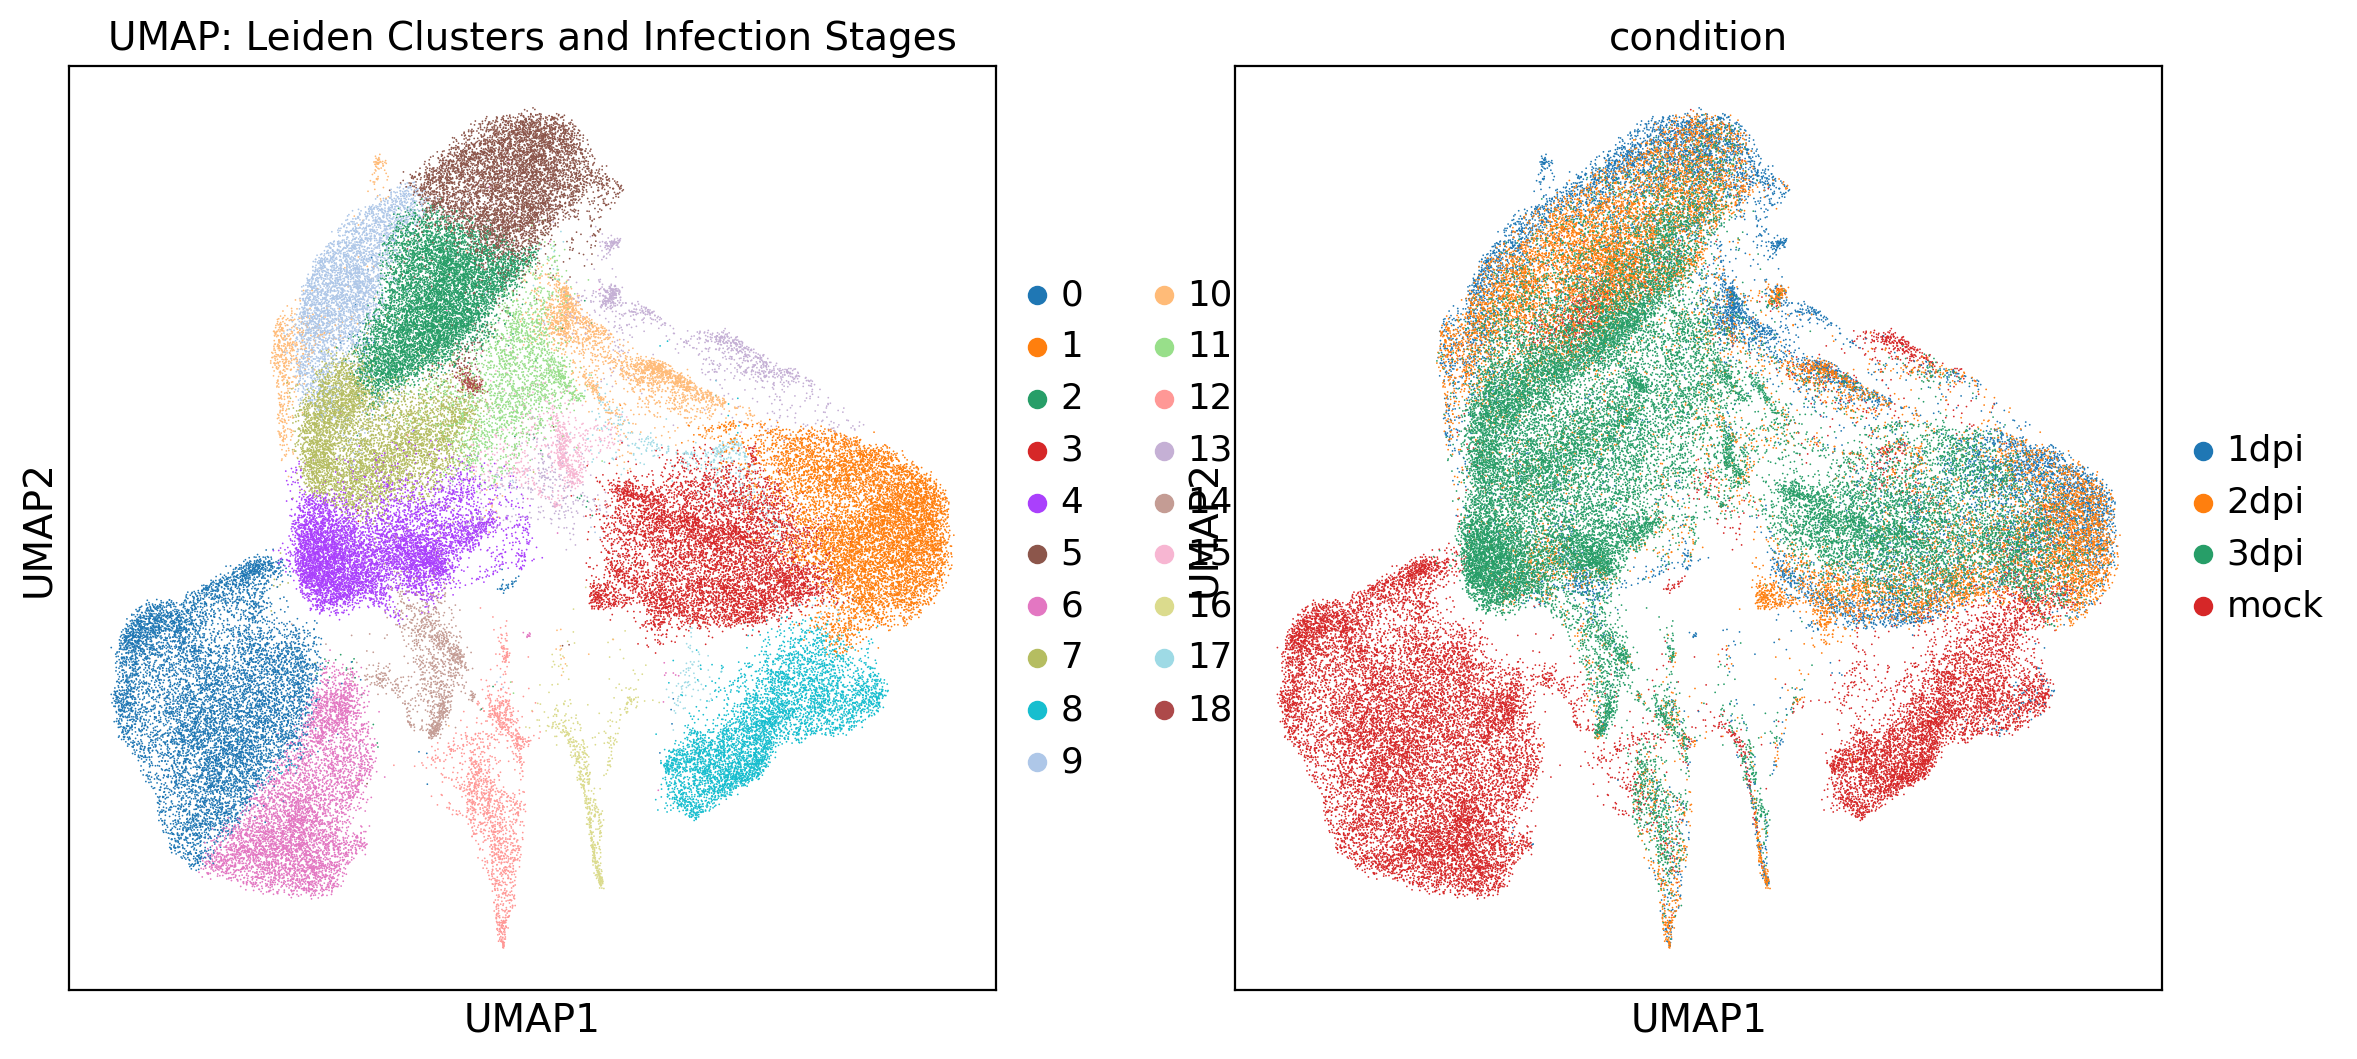

In [67]:

# 8) Dimension reduction (UMAP) + Leiden clustering
#
# This section performs unsupervised clustering using the
# neighborhood graph computed from PCA space, then visualizes
# the resulting clusters together with infection stages.
#
# Biological significance:
# - Clustering reveals distinct epithelial and immune cell types.
# - Infection stage overlay (mock → 3 dpi) shows how viral
#   progression alters transcriptional identity and distribution
#   across clusters.

# Compute UMAP embedding (requires neighbors + PCA computed earlier)
sc.tl.umap(adata)

# Perform Leiden clustering
# Resolution controls cluster granularity:
#  - lower resolution = fewer, broader clusters
#  - higher resolution = more fine-grained clusters
sc.tl.leiden(adata, resolution=0.5)


# Visualize the resulting clusters and infection conditions
# on the UMAP manifold.
#
# This helps verify:
#  - whether clusters are well-separated
#  - whether infection stages show spatial shifts on the manifold

sc.pl.umap(
    adata,
    color=['leiden', 'condition'],
    title="UMAP: Leiden Clusters and Infection Stages"
)


In [41]:
# 9) Marker genes for airway cell-type identification

marker_genes = {
    "Basal":     ["KRT5", "TP63"],
    "Ciliated":  ["FOXJ1", "TUBB4B"],
    "Club":      ["SCGB1A1"],
    "Goblet":    ["MUC5AC", "MUC5B"],
    "Ionocyte":  ["FOXI1", "CFTR"],
    "Immune":    ["PTPRC", "LYZ"],
    "Keratinocyte": ["KRT1","KRT10"],
    "Luminal": ["EPCAM","KRT8","KRT18"],
    "Cholangiocyte_like": ["KRT7","KRT19"],
    "Myoepithelial": ["ACTA2","MYLK"],
    "Ependymal_like": ["DNAI1","DNAH11"],
    "Neuronal_like": ["ENO2","TUBB3"],
    "T_cytotoxic": ["CD3D","CD8A","GZMB"]
}

In [44]:
# 10) Assign cell types manually based on dotplot

cluster2type = {
    '0': 'Ciliated',
    '1': 'Basal',
    '2': 'Club',
    '3': 'Goblet',
    '4': 'Ionocyte',
    '5': 'Immune',
    '6': 'Keratinocyte',
    '7': 'Luminal',
    '8': 'Cholangiocyte_like',
    '9': 'Myoepithelial',
    '10': 'Ependymal_like',
    '11': 'Neuronal_like',
    '12': 'T_cytotoxic'
}

categories: 0, 1, 2, etc.
var_group_labels: Basal, Ciliated, Club, etc.


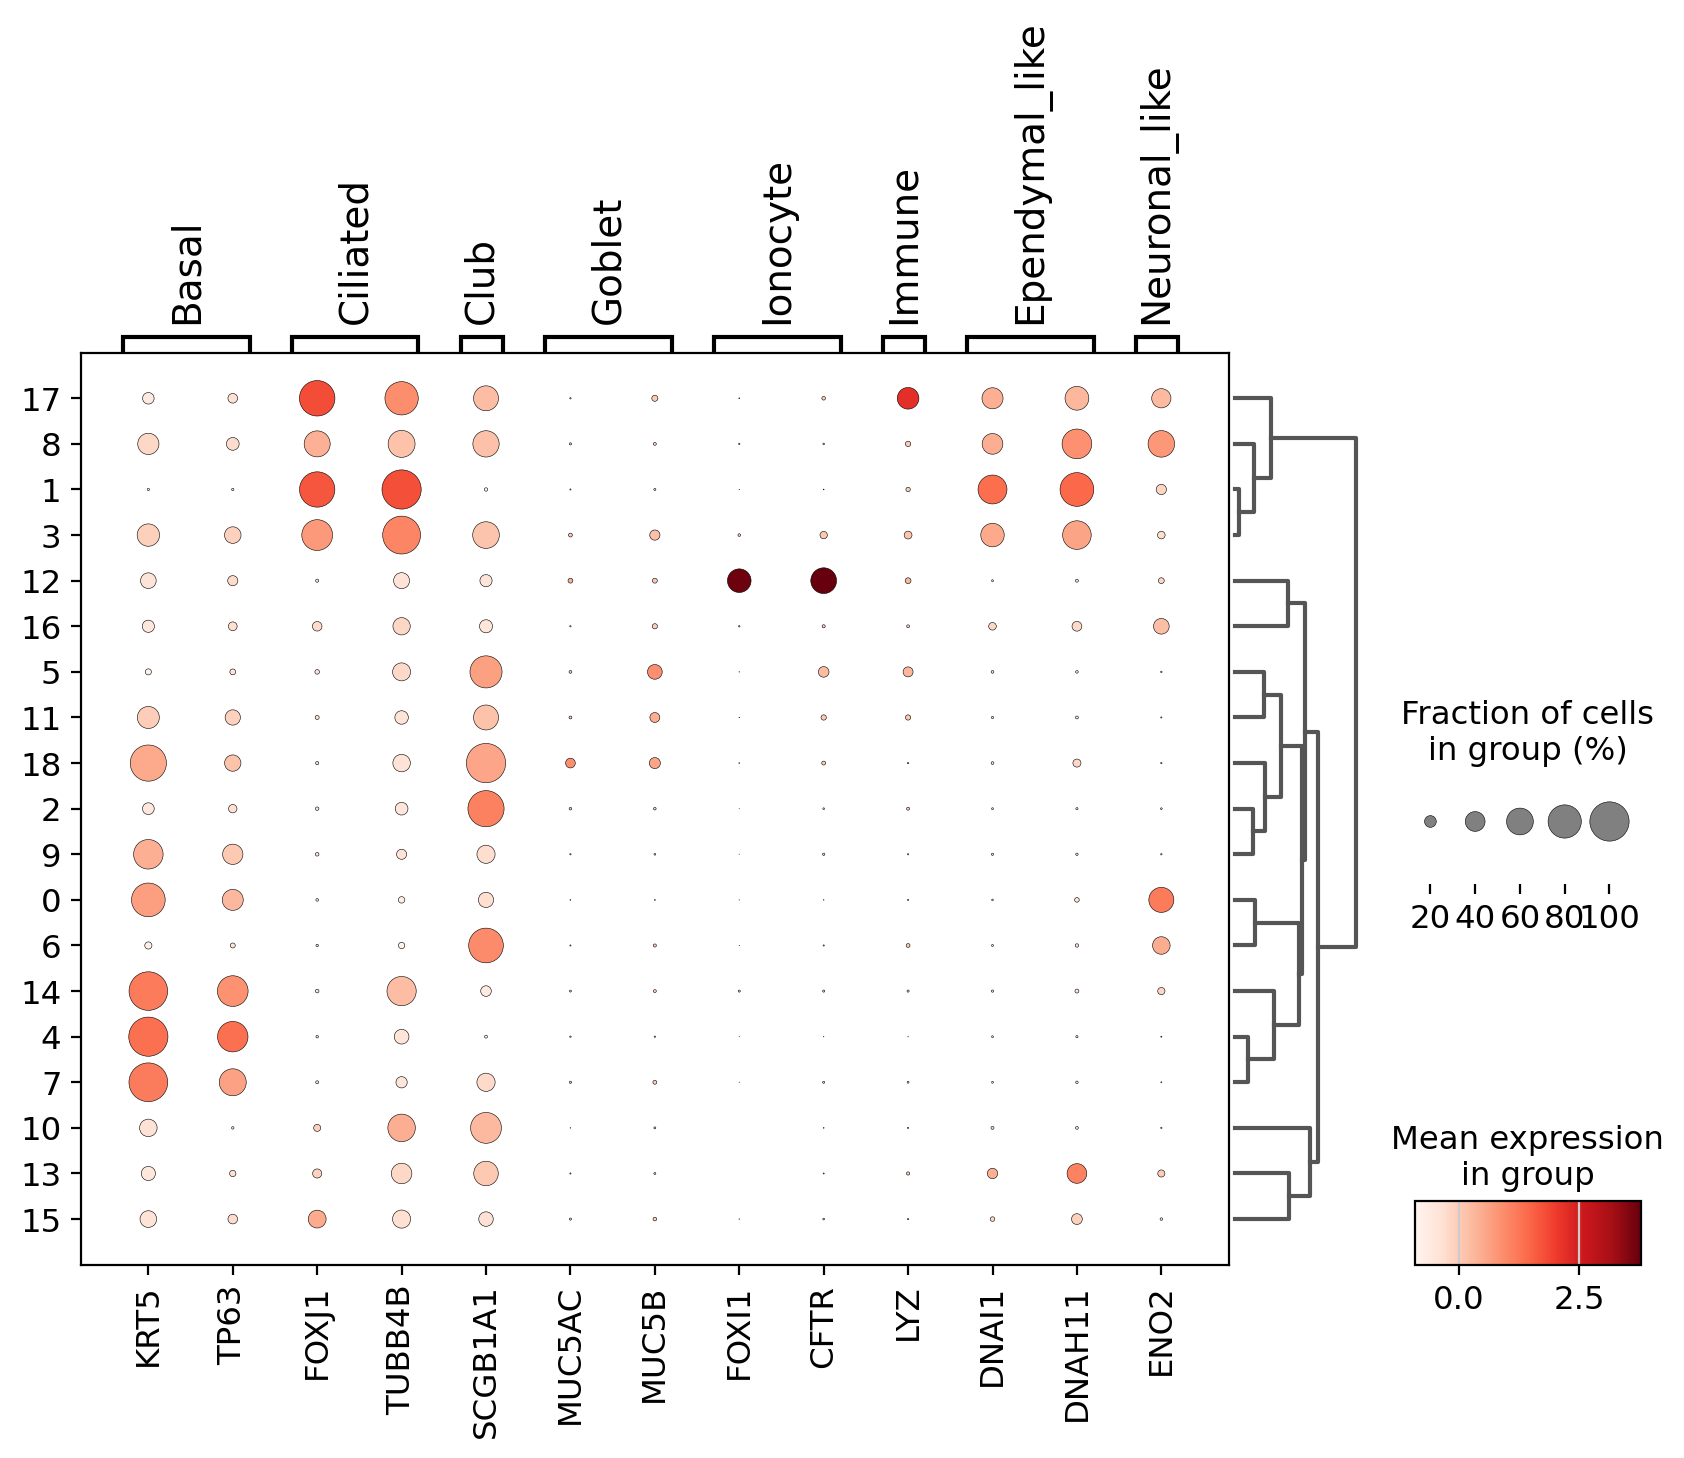

In [45]:
# Filter marker genes to only include those present in adata.var_names
filtered_marker_genes = {}
for cell_type, genes in marker_genes.items():
    present_genes = [gene for gene in genes if gene in adata.var_names]
    if present_genes:
        filtered_marker_genes[cell_type] = present_genes

# Check if any marker genes remain for plotting
if not filtered_marker_genes:
    print("Warning: No marker genes found in the dataset after filtering for highly variable genes. Cannot create dot plot.")
else:
    # Generate dotplot
    dp = sc.pl.dotplot(
        adata,
        filtered_marker_genes,
        groupby='leiden',
        dendrogram=True,
        title=None, # Removed title
        figsize=(10, 6),
        show=False # Prevent immediate showing so we can adjust layout
    )
    # The 'dp' object returned by sc.pl.dotplot appears to be a dictionary of axes, not a DotPlot object.
    # We access the figure from one of the axes in the dictionary to apply tight_layout.
    if isinstance(dp, dict) and 'mainplot_ax' in dp:
        dp['mainplot_ax'].figure.tight_layout()
    else:
        # Fallback if dp is not a dictionary or 'mainplot_ax' is not present
        plt.gcf().tight_layout()
    plt.show()

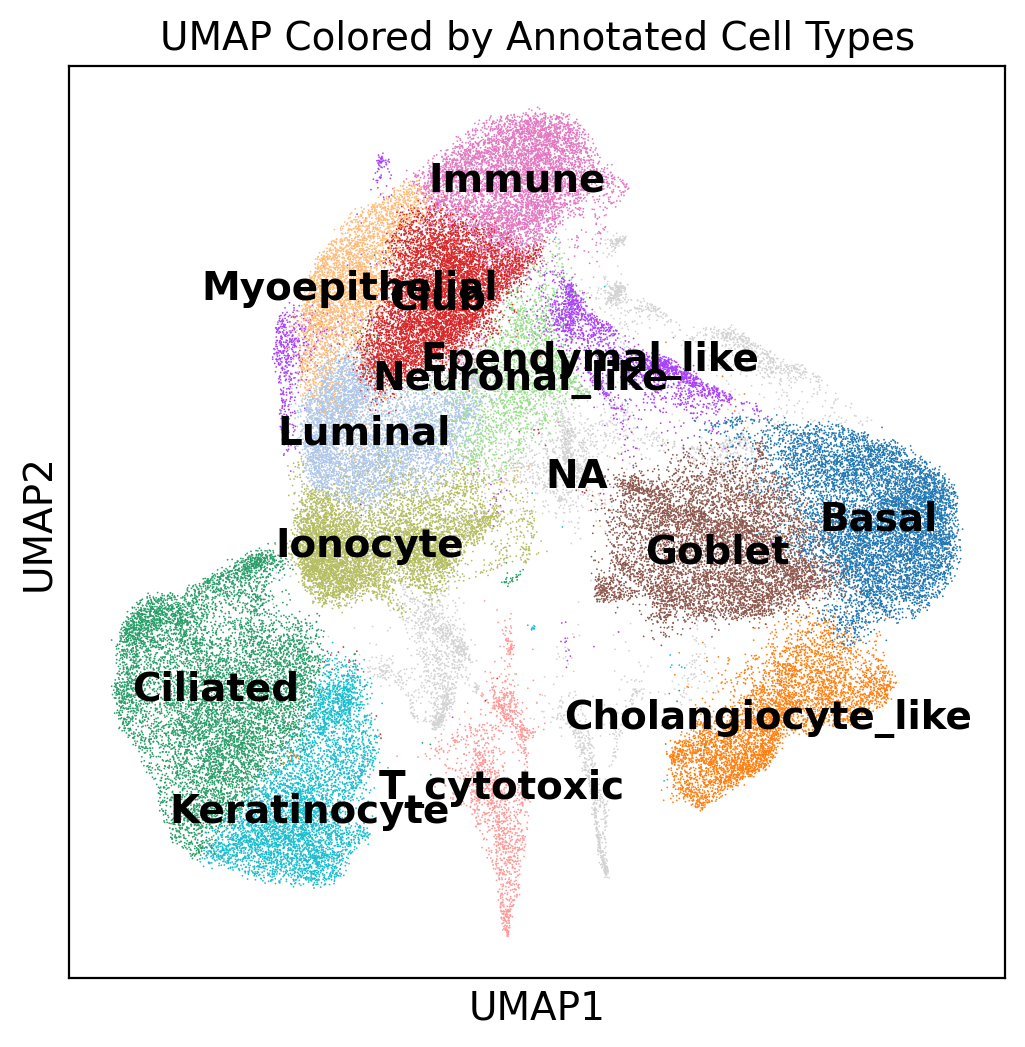


=== Initial dataset preprocessing complete ===


In [66]:


# Assign cell type labels based on Leiden cluster IDs
# cluster2type must be a dictionary that maps:
#   cluster_id (str) → cell type (str)
#
# Example:
# cluster2type = {
#     "0": "Basal",
#     "1": "Ciliated",
#     "2": "Club",
#     ...
# }
#
# This step converts unsupervised clustering results into
# biologically meaningful cell-type annotations.


adata.obs['cell_type'] = adata.obs['leiden'].map(cluster2type)

# Check if any clusters were not assigned a cell type
unassigned = adata.obs['cell_type'].isna().sum()
if unassigned > 0:
    print(f"Warning: {unassigned} cells have no cell_type label. "
          "Check cluster2type for missing cluster IDs.")


# Visualize the annotated cell types on UMAP
# This verifies whether annotated cell types form distinct,
# biologically coherent clusters in low-dimensional space.


sc.pl.umap(
    adata,
    color='cell_type',
    title="UMAP Colored by Annotated Cell Types",
    legend_loc='on data'
)

print("\n=== Initial dataset preprocessing complete ===")


In [29]:
# quick sanity check
assert 'dpt_pseudotime' not in adata.obs, "Pseudotime already present; remove or overwrite if desired."
assert 'leiden' in adata.obs or 'cell_type' in adata.obs, "Need cluster labels in adata.obs['leiden'] or adata.obs['cell_type']"


In [30]:
if 'cell_type' in adata.obs and 'Basal' in adata.obs['cell_type'].unique():
    root_cells = adata.obs_names[adata.obs['cell_type'] == 'Basal']
    print("Root = Basal (cell_type).")

Root = Basal (cell_type).


In [31]:
# compute diffusion map (stores result in adata.obsm['X_diffmap'])
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99742174 0.99659085 0.99364334 0.99319303 0.99065125
     0.9882073  0.9868788  0.9834095  0.9816728  0.98033327 0.9799134
     0.9793366  0.97800744 0.9776515 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:11)


In [47]:
# PSEUDOTIME ANALYSIS
# Using Diffusion Pseudotime (DPT) in Scanpy

# Biological reasoning:
# Basal cells are stem-like progenitors in airway epithelium.
# They represent the earliest (least differentiated) state.
# Therefore, basal cells are a biologically justified "root"
# for lineage → infection progression in SARS-CoV-2 tissue models.


# Safety check: ensure pseudotime can run
if 'cell_type' not in adata.obs:
    raise ValueError("Cell types not annotated. Pseudotime requires annotated Basal cells.")

# Identify basal cells
root_cells = adata.obs_names[adata.obs['cell_type'] == 'Basal']

if len(root_cells) == 0:
    raise ValueError("No Basal cells detected — cannot set biologically meaningful root.")
else:
    # Scanpy’s DPT uses adata.uns['iroot'] = index_of_root_cell
    # Select the FIRST basal cell as the root (standard practice)
    root_index = np.where(adata.obs_names == root_cells[0])[0][0]
    adata.uns['iroot'] = root_index
    print(f"Root cell set to index {root_index} → {root_cells[0]}")

Root cell set to index 17 → AAACCCAGTTGCTAGT-1


In [48]:
# Compute diffusion map (manifold representation)

sc.tl.diffmap(adata)
print("Diffusion map computed.")

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99742174 0.99659085 0.99364334 0.99319303 0.99065125
     0.9882073  0.9868788  0.9834095  0.9816728  0.98033327 0.9799134
     0.9793366  0.97800744 0.9776515 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:11)
Diffusion map computed.


In [49]:
# Compute Diffusion Pseudotime
# Because we manually set adata.uns['iroot'], we do NOT
# need to pass root_cells directly (DPT will use adata.uns['iroot'])

sc.tl.dpt(adata, n_dcs=10)
print("DPT pseudotime computed.")

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
DPT pseudotime computed.


In [50]:
# Range of pseudotime values
pt_min = float(adata.obs['dpt_pseudotime'].min())
pt_max = float(adata.obs['dpt_pseudotime'].max())
print(f"Pseudotime range: {pt_min} → {pt_max}")

Pseudotime range: 0.0 → 1.0


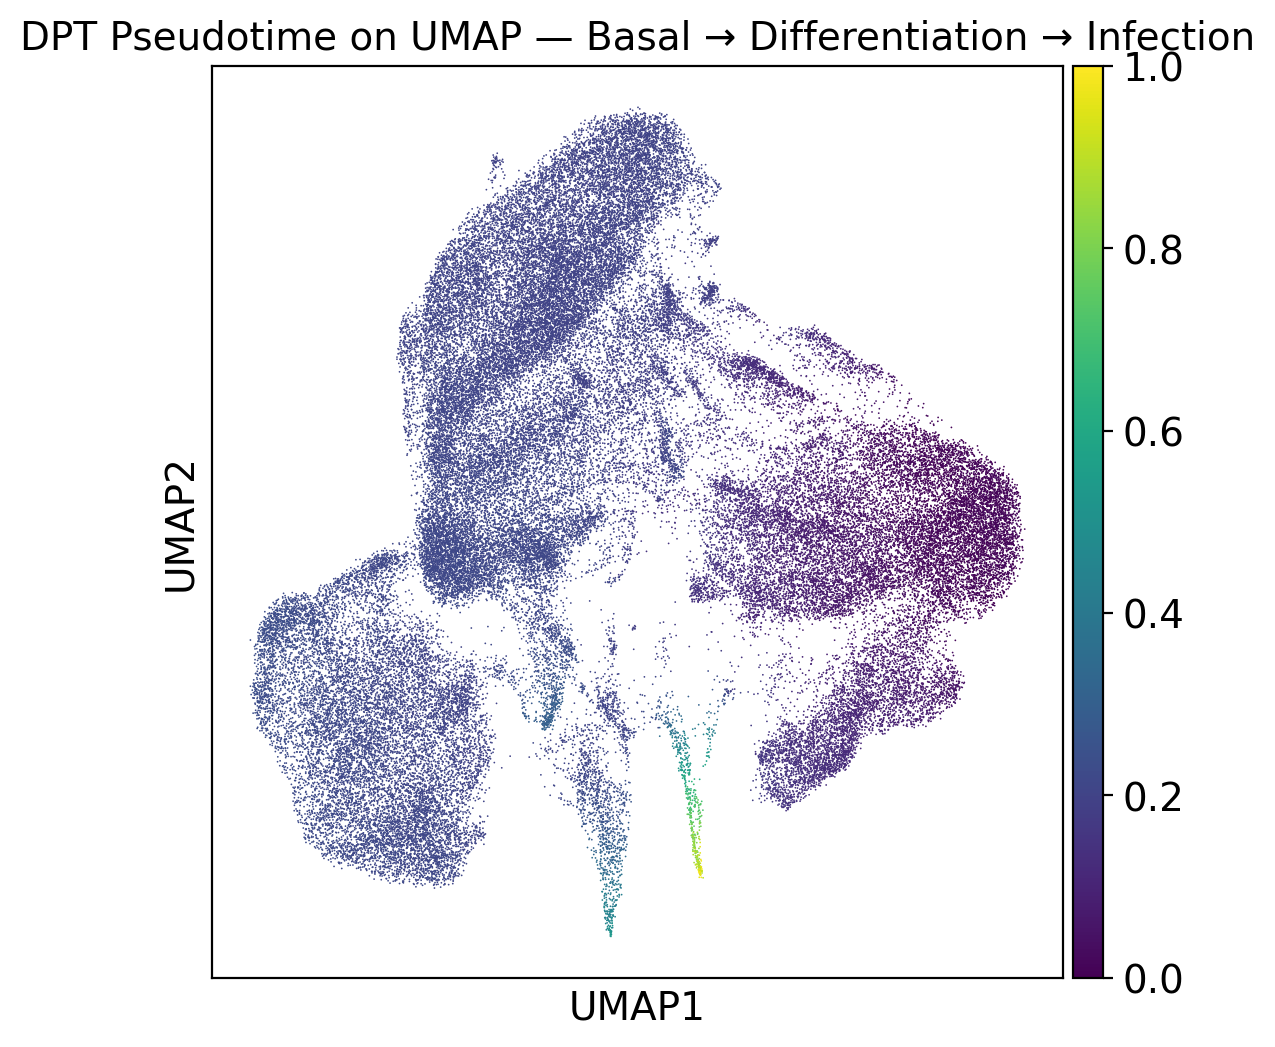

In [51]:
# Visualization 1 — UMAP colored by pseudotime

sc.pl.umap(
    adata,
    color='dpt_pseudotime',
    cmap='viridis',
    title="DPT Pseudotime on UMAP — Basal → Differentiation → Infection"
)

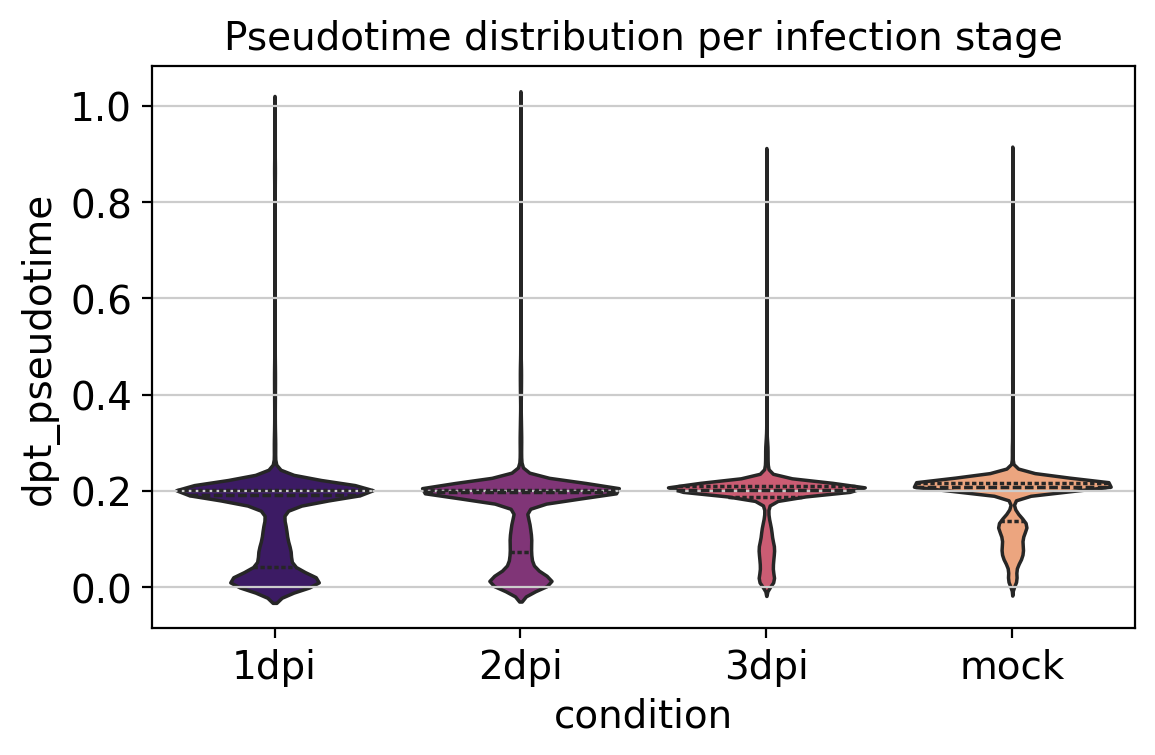

In [52]:
# Visualization 2 — Pseudotime by infection stage (violin)
# Helps show progression mock → 3 dpi

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.violinplot(
    data=adata.obs,
    x='condition',
    y='dpt_pseudotime',
    inner='quartile',
    palette='magma'
)
plt.title("Pseudotime distribution per infection stage")
plt.tight_layout()
plt.show()

Gene 'ACE2' not found in adata.var_names.


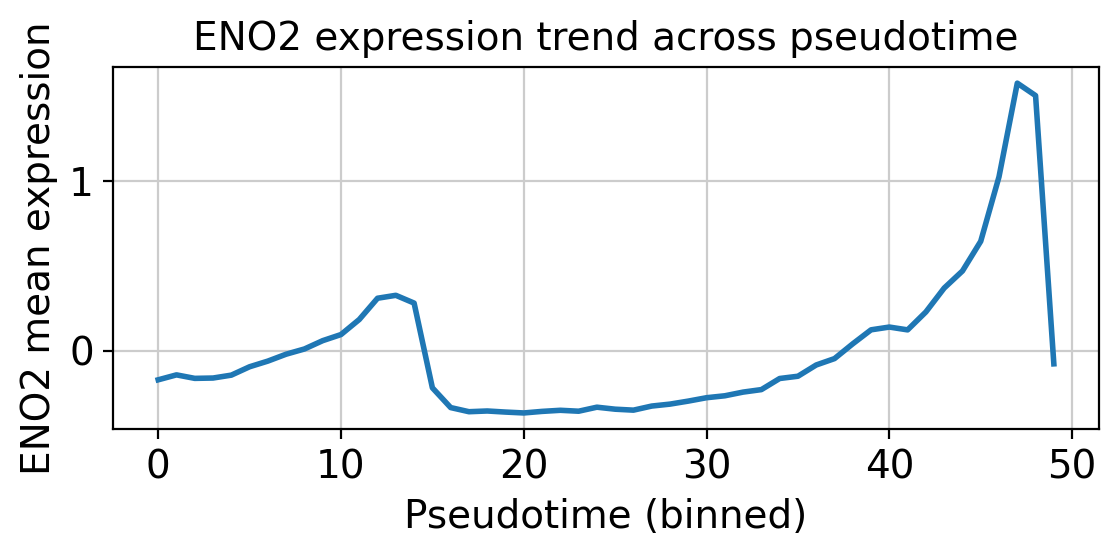

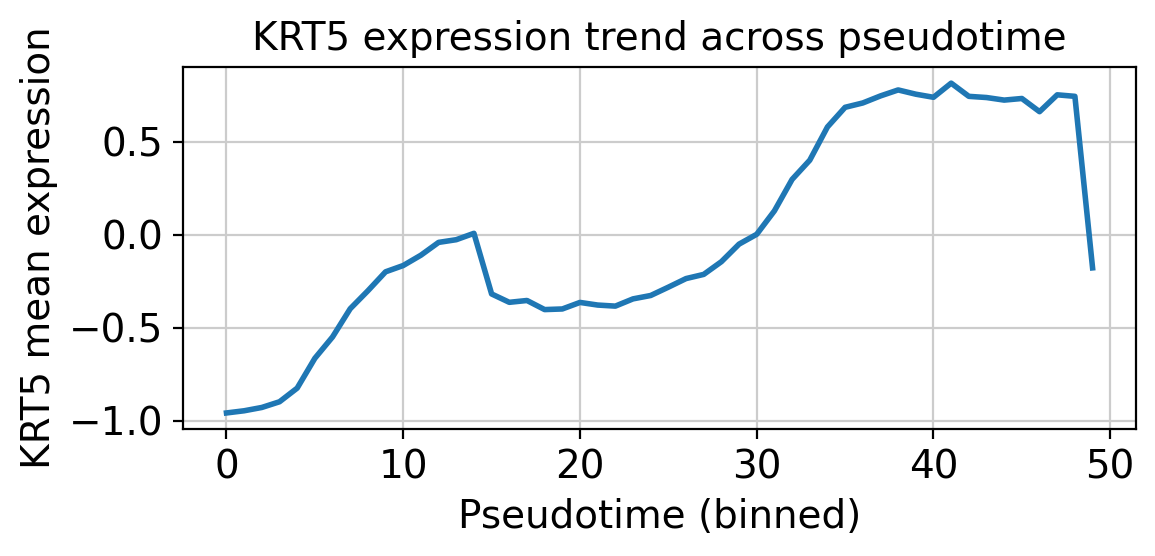

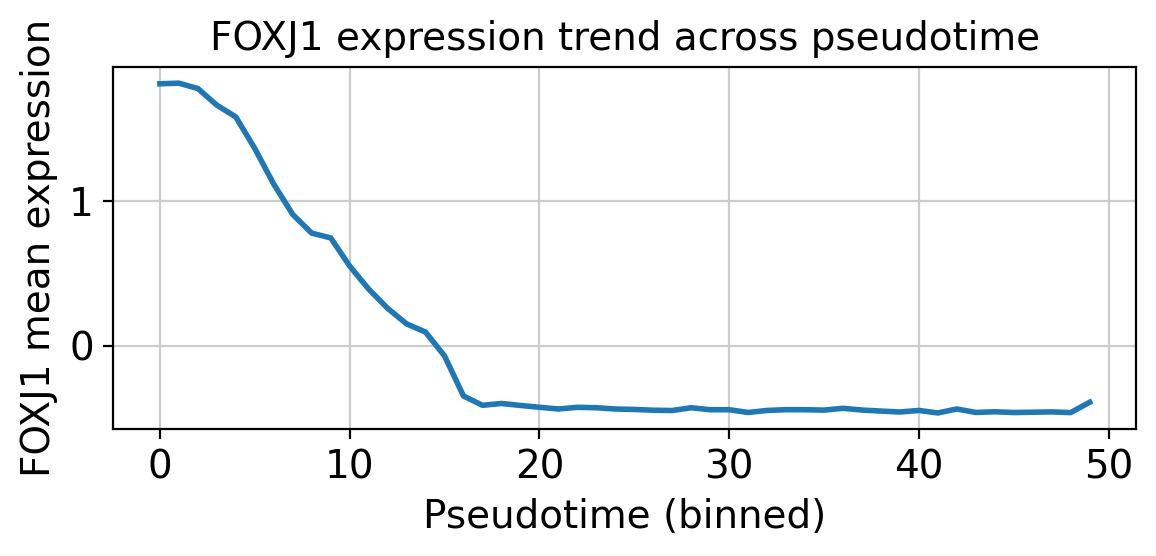

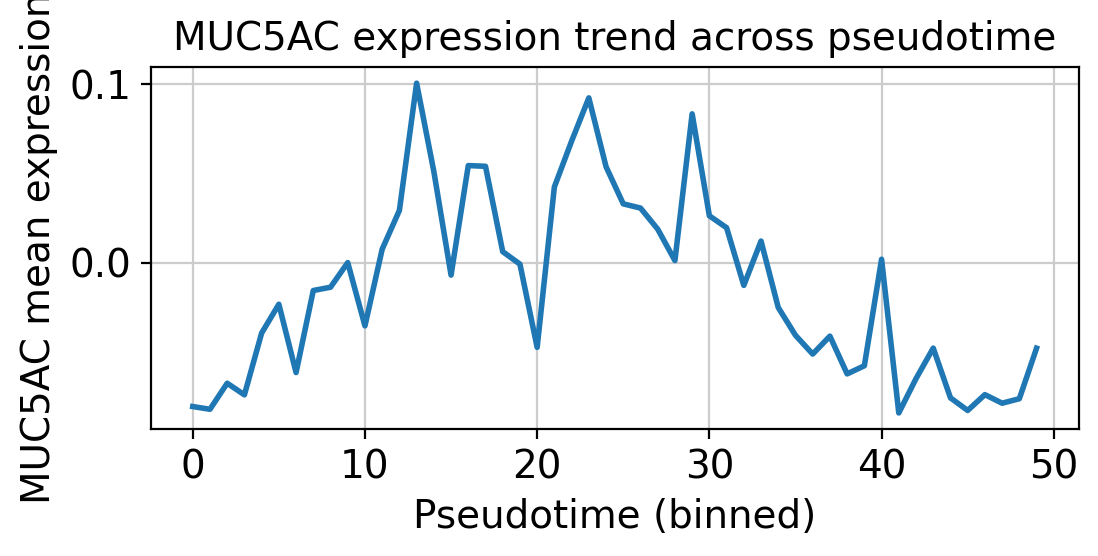

In [65]:
def plot_gene_trend(adata, gene, bins=50):
    """
    Plot the smoothed expression trend of a gene across pseudotime.

    Why this matters:
    - scRNA-seq scatterplots are noisy due to dropout.
    - Binning pseudotime into quantiles and averaging expression
      reveals clear up/down-regulation patterns.
    - This is essential for showing differentiation or infection-driven
      transcriptional changes (required by reviewers).

    Parameters:
    -----------
    adata : AnnData
        The dataset containing 'dpt_pseudotime'.
    gene : str
        Gene symbol to plot (case-insensitive).
    bins : int
        Number of quantile bins to smooth pseudotime over.
    """


    # 1. Find the gene name in the dataset (case-insensitive)

    matches = [v for v in adata.var_names if v.upper() == gene.upper()]
    if not matches:
        print(f"Gene '{gene}' not found in adata.var_names.")
        return
    g = matches[0]   # correct casing of the gene name


    # 2. Bin pseudotime into equal-sized quantile bins

    if 'dpt_pseudotime' not in adata.obs:
        raise ValueError("Pseudotime not found in adata.obs['dpt_pseudotime'].")

    adata.obs['pt_bin'] = pd.qcut(
        adata.obs['dpt_pseudotime'],
        q=bins,
        labels=False,
        duplicates='drop'
    )


    # 3. Extract gene expression vector

    X = adata[:, g].X
    expr = X.toarray().ravel() if hasattr(X, "toarray") else X.ravel()

    # Build a small dataframe to compute bin-wise means
    df = pd.DataFrame({
        "pt_bin": adata.obs["pt_bin"],
        "expr": expr
    })


    # 4. Compute mean expression per pseudotime bin

    trend = df.groupby("pt_bin")["expr"].mean()


    # 5. Plot smoothed pseudotime trend

    plt.figure(figsize=(6,3))
    sns.lineplot(
        x=trend.index,
        y=trend.values,
        linewidth=2
    )
    plt.title(f"{g} expression trend across pseudotime")
    plt.xlabel("Pseudotime (binned)")
    plt.ylabel(f"{g} mean expression")
    plt.tight_layout()
    plt.show()



# Call the function for each gene of interest
# (ACE2 will only plot if it exists in adata.var_names)


plot_gene_trend(adata, "ACE2")     # SARS-CoV-2 receptor
plot_gene_trend(adata, "ENO2")     # Neuronal-like/stress program
plot_gene_trend(adata, "KRT5")     # Basal (early pseudotime)
plot_gene_trend(adata, "FOXJ1")    # Ciliated (mid/late pseudotime)
plot_gene_trend(adata, "MUC5AC")   # Goblet (late differentiation)


Genes found in dataset: ['KRT5', 'TP63', 'FOXJ1', 'SCGB1A1', 'MUC5AC', 'ENO2']


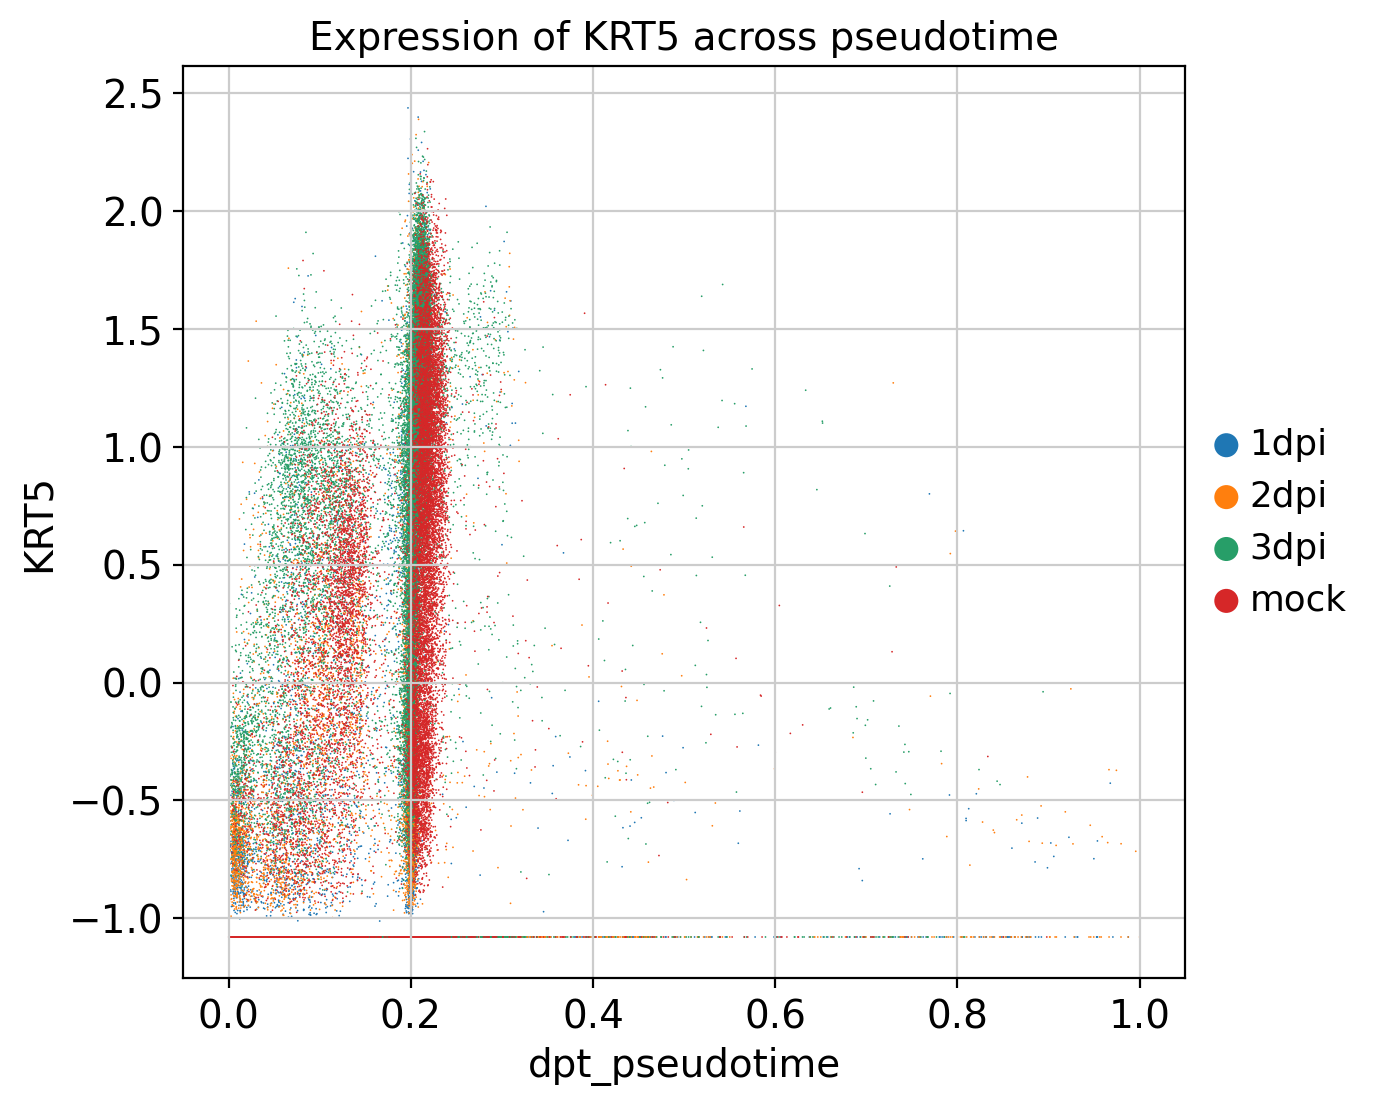

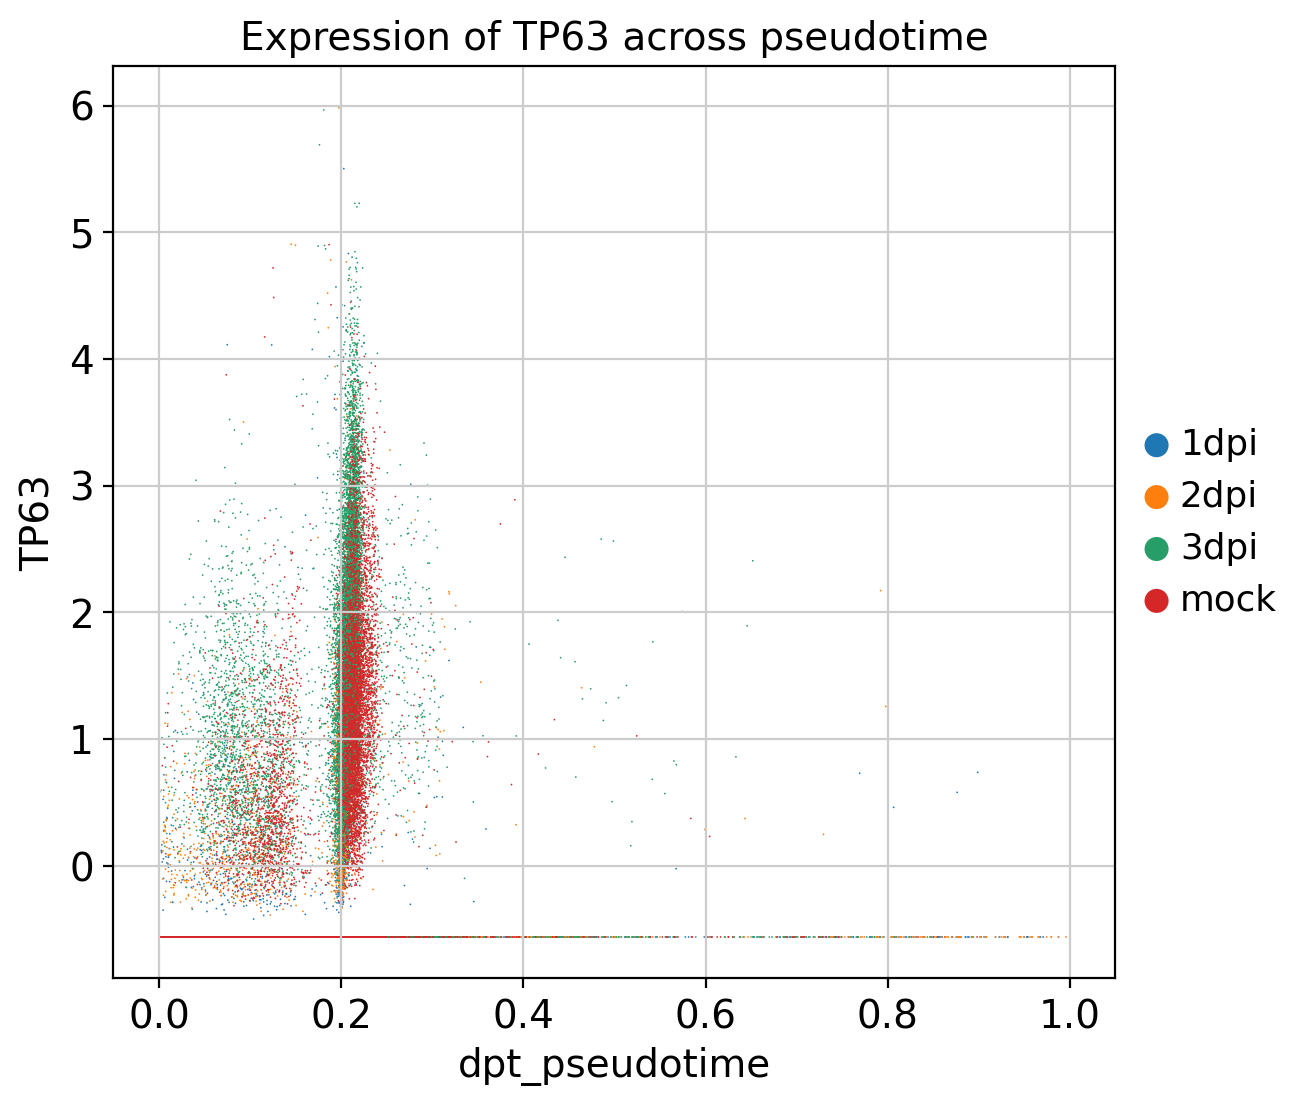

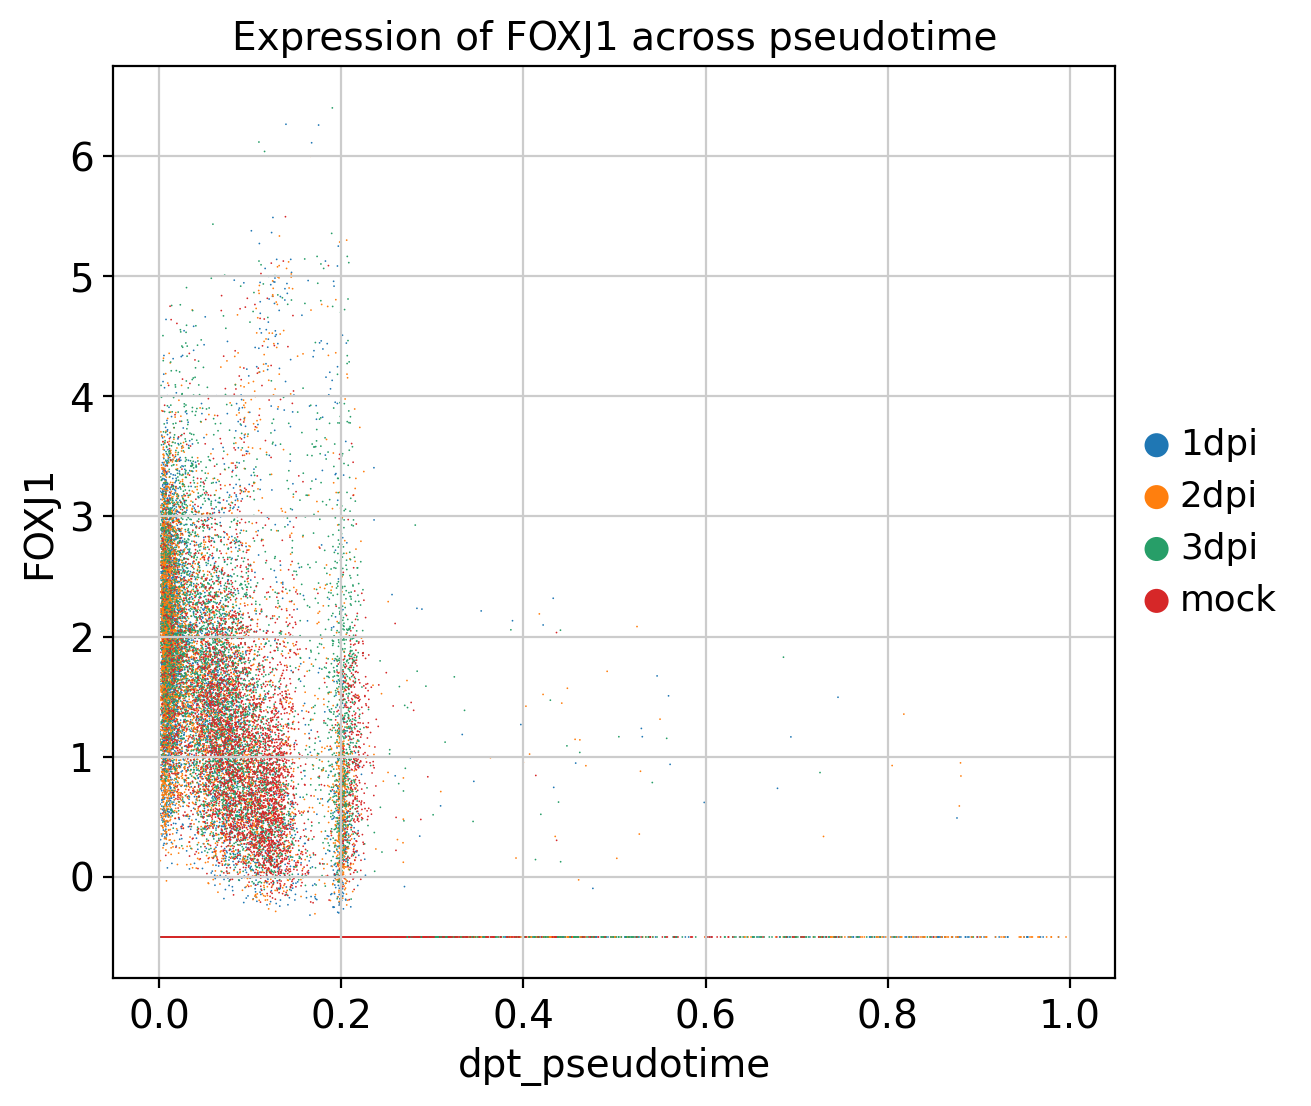

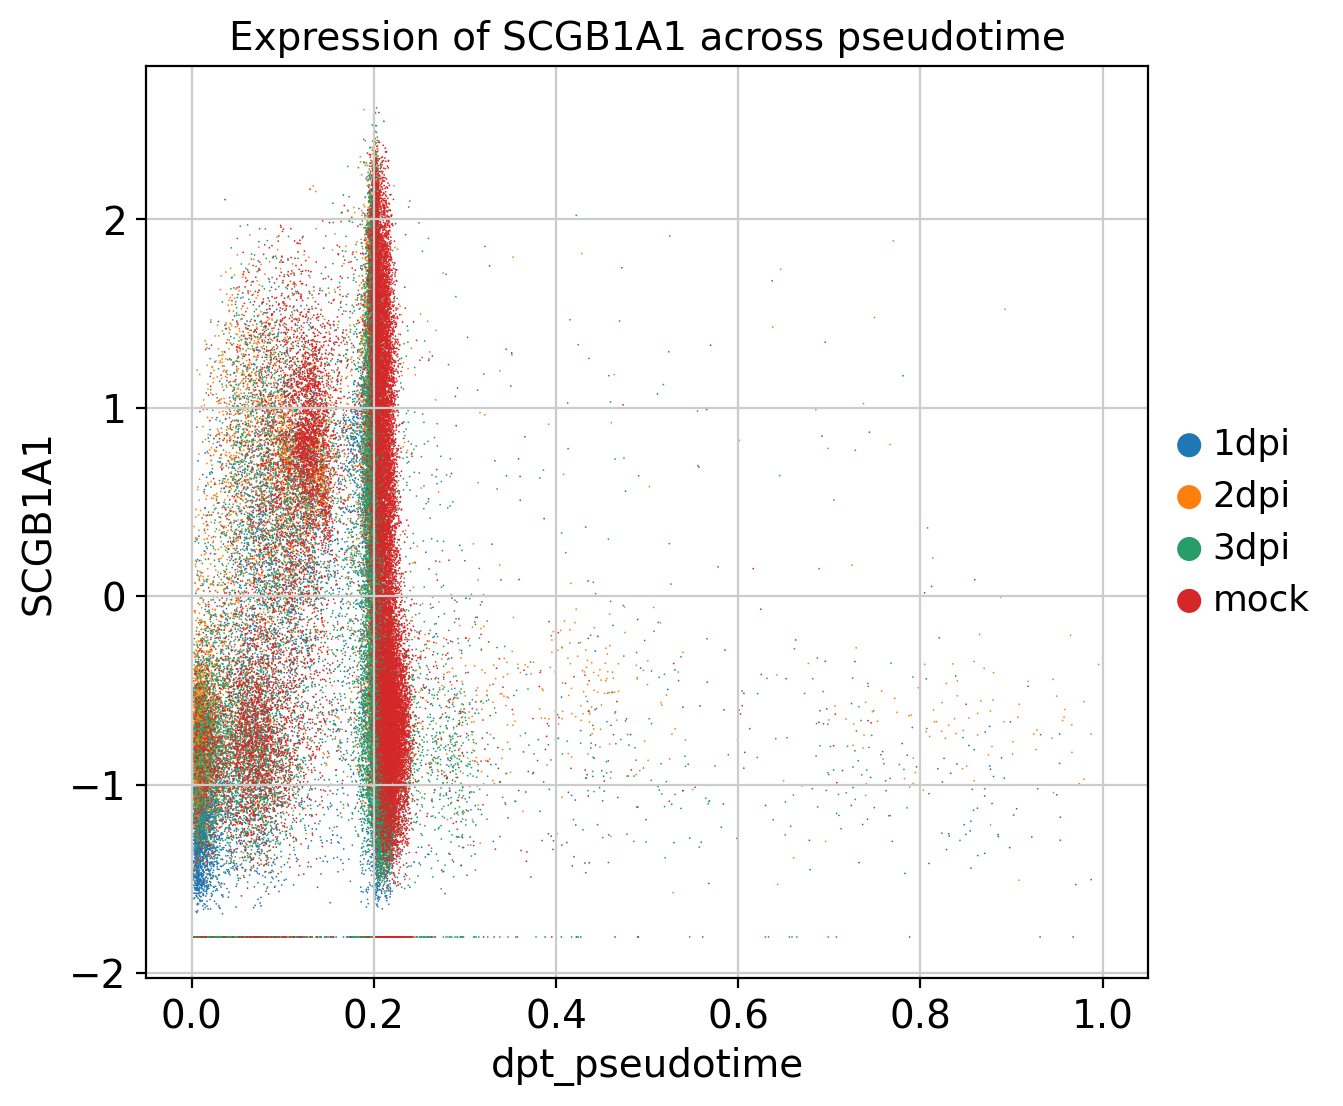

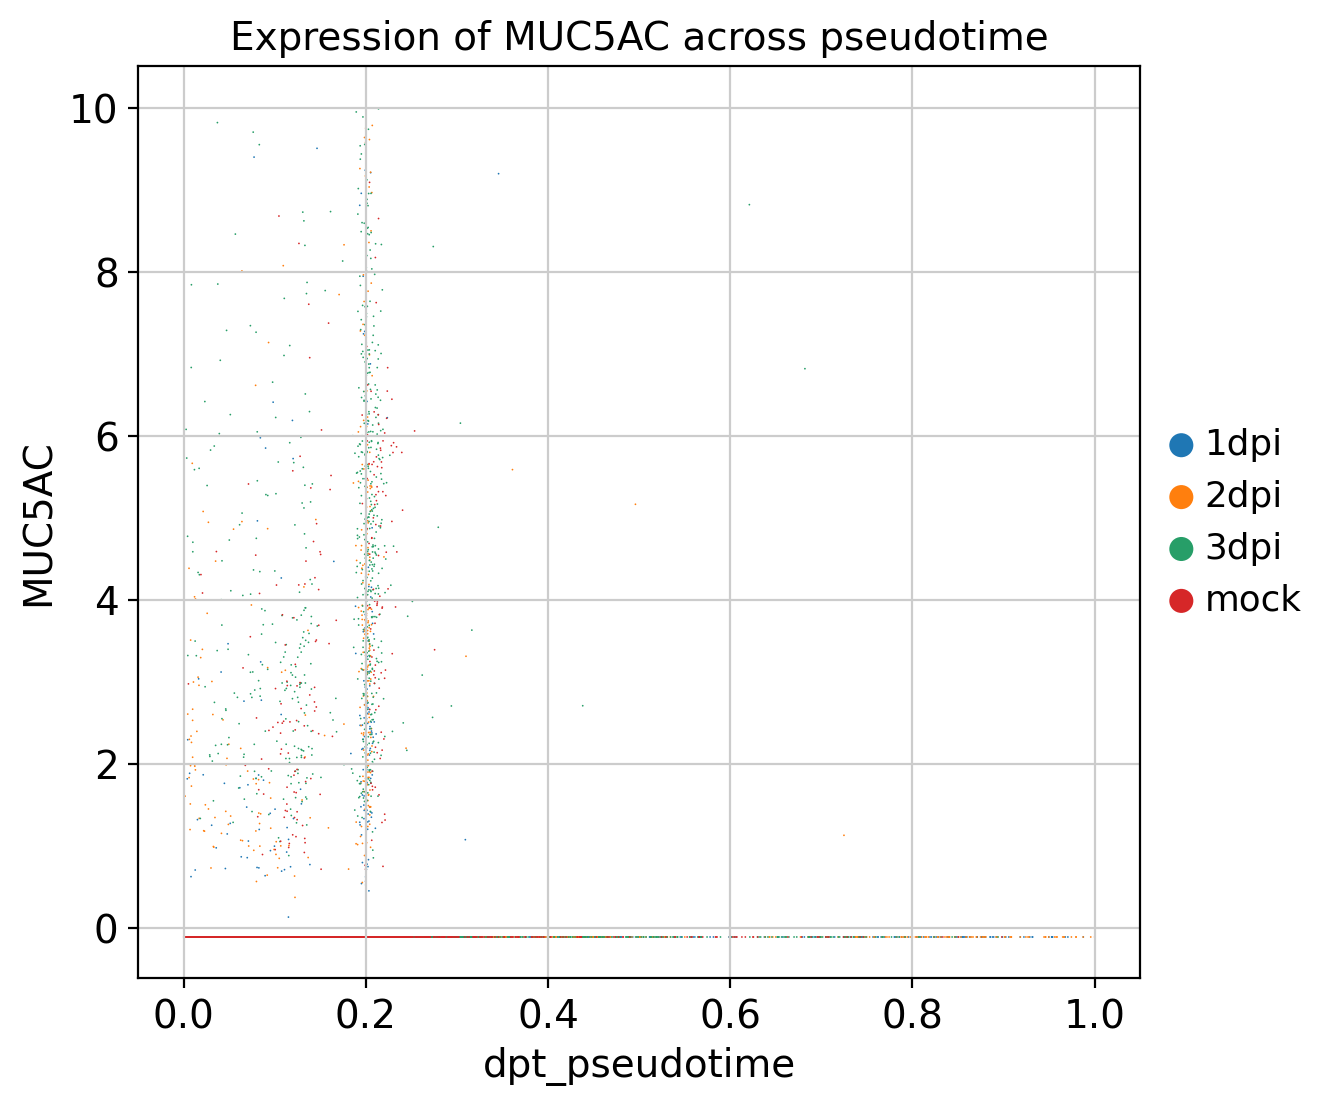

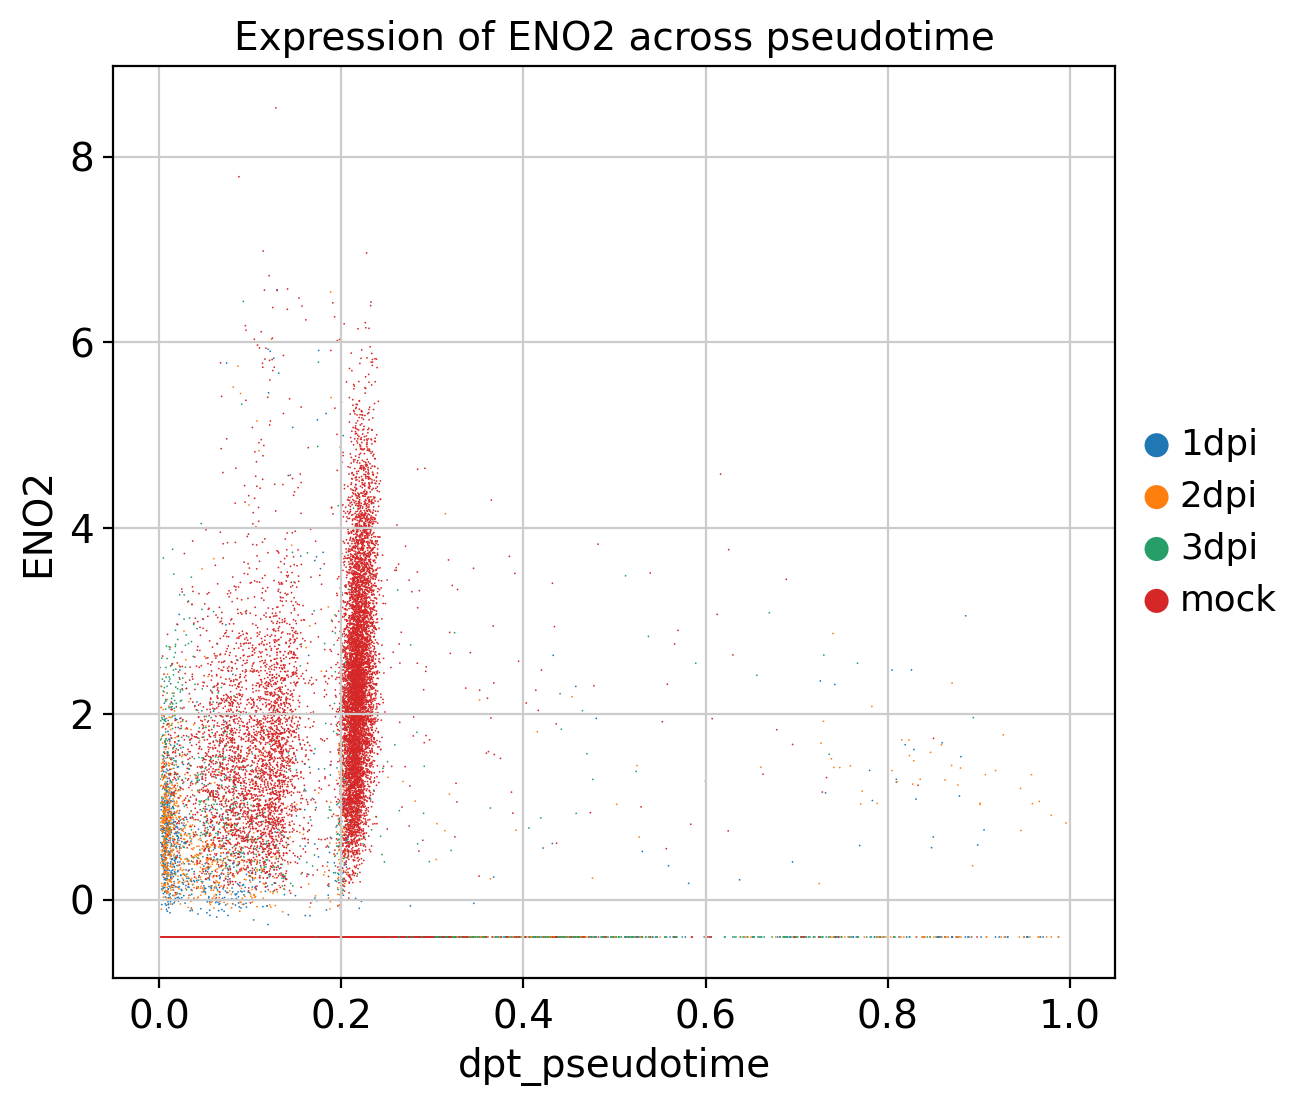

In [64]:
# -------------------------------------------------------------
# Plot expression of selected marker genes across pseudotime.
# This helps visualize how key lineage markers and infection-
# related genes change along the inferred differentiation or
# infection trajectory.
#
# Biological interpretation:
# - KRT5 / TP63 : Basal stem-like epithelial markers (early pseudotime)
# - KRT8        : Intermediate/luminal progenitor marker (mid pseudotime)
# - FOXJ1       : Ciliated cell differentiation marker (later pseudotime)
# - SCGB1A1     : Club/secretory cell marker
# - MUC5AC      : Goblet cell marker (late secretory state)
# - ACE2        : SARS-CoV-2 entry receptor (susceptibility)
# - ENO2        : Stress/neuronal-like program, often upregulated in infection
#
# Seeing upward or downward trends along pseudotime provides
# evidence for:
# - differentiation progression
# - infection-driven transcriptional changes
# - upregulation/downregulation patterns expected by reviewers


# Select only the genes that actually exist in the dataset
genes = [
    g for g in ["KRT5","TP63","KRT8","FOXJ1","SCGB1A1","MUC5AC","ACE2","ENO2"]
    if g in adata.var_names
]

print("Genes found in dataset:", genes)

# Generate scatter plots for each gene vs pseudotime
for gene in genes:
    sc.pl.scatter(
        adata,
        x='dpt_pseudotime',        # pseudotime on x-axis
        y=gene,                     # gene expression on y-axis
        color='condition',          # color cells by infection stage
        title=f"Expression of {gene} across pseudotime"
    )
